# Computer Price regression


## Modelling objective


> To build an **optimal** and accurate model to estimate computer prices, by using Root Mean Squared Error (RMSE) as our main metric for evaluation

## Prediction task & Background research

> ***Can we utilize machine learning to help potential PC buyers determine the price of a computer given its specifications and components?***

The dataset provided is collected from a PC website, containing `15320` data points with `12` columns. It includes the specifications as well as the hardware components of each laptop, as well as `Price ($)` as the numerical target variable, which is continuous in nature.

1. Hence, our task is to develop a regression model by leveraging on labelled data to assist potential PC buyers/and or sellers, to accurately predict the price of PCs.
2. We also want to gain further insights on factors that affect the PC prices, (that is the most important component/aspect.)

### Understanding the problem
> **Recognising the importance of good decision making**

1. For many individuals, the price of a laptop plays a large decisive role. When we purchase PCs, each of us would attempt to get the best equipment at the lowest possible price. However, we may overlook some specifications/components when picking the ideal PC. For instance, getting a PC of a famous/luxurious brand with exorbitant costs, may not necessarily suit oneself which will lead to regrets.
1. Given the difficult dilemma of selecting a perfect PC, we need to decide what is the purpose of purchasing the PC.
PCs are used in a variety of settings, such as at work, educational purposes, gaming, web browsing, personal multimedia, or for general home computer use.
2. In most cases, getting a PC with an average CPU performance and integrated video card is sufficient. However, a more robust and efficient CPU may be needed for other purposes such as gaming.

#### Predictive Pricing
1. Benefits both retailer and customer.
2. Do not have to go through inconvenience of scrutinizing each component/aspect to determine its price.
3. By utilizing machine learning to help assess the specifications, manufacturers will be able to set a competitive price that appeals to customers, which will help maximize profits.
4. From the customers' perspective, predictive models can prevent them from overspending as well as getting scammed.

**Marketing Strategies**
- Manufacturers have been actively trying to promote the latest PC brand, claiming it to possess the most up to date and best components available, while this might be true, the differences in performance between the newer and older brands are meagre, and may not be obvious. 
- It is therefore easy to succumb to marketing traps and confusion with regards to costs.
- Moreover, a consumer may not be well versed with the current market prices, and might be drawn to the idea of having the best equipment, and as such willing to purchase the newer brands at a much higher price point even though they work just as well as the older brands.
<!-- - Moreover, a consumer may not be well versed with the current market price, which may lead them to ultimately overspend. -->

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy import stats
from IPython.display import display
import warnings
from statsmodels.api import qqplot
warnings.filterwarnings('ignore')
sns.set()
%matplotlib inline


In [2]:
# pip install phik
# Please install
import phik
from phik import resources, report
from phik.report import plot_correlation_matrix

In [3]:
# Regression models
from sklearn.svm import LinearSVR,SVR,NuSVR
# from sklearn.neural_network import MLPRegressor
from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso,BayesianRidge,SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor,BaggingRegressor,AdaBoostRegressor


# Tools to help with data preprocessing
from sklearn.pipeline import make_pipeline,Pipeline,FeatureUnion,make_union
from sklearn.compose import ColumnTransformer,make_column_transformer, TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, QuantileTransformer, PolynomialFeatures, OneHotEncoder, PowerTransformer
from sklearn.decomposition import PCA


# Hyperparameter optimization
from sklearn.model_selection import GridSearchCV


# Feature Selection
from sklearn.feature_selection import SelectKBest,SelectFromModel, RFECV, SelectKBest, mutual_info_regression, RFE

# model evaluation
from sklearn.model_selection import train_test_split, cross_validate, KFold, learning_curve,validation_curve
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error,SCORERS,make_scorer

# Feature importance for interpretability
from sklearn.inspection import permutation_importance

#Base
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.base import clone


## Reading from csv file

This dataset contains the aspects/**specifications** and cost of computers collected from a PC website
* Target variable is `Price ($)`
* We can see that product ID may not provide any information towards our target variable
* We may have to perform some potential feature engineering steps on some of the component features like CPU/Hard disk.

In [4]:
pc_df = pd.read_csv('datasets/pc_data.csv',sep=',', na_values='?')
# Denote null values as ?
pc_df.head()

,Product ID,Brand,Type,Screen Size,Screen Specs,CPU,RAM,Hard Disk,GPU,Operating System,Weight,Price ($)
0,0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,3568.93416
1,1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,2394.77616
2,2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,1531.80000
3,3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,6759.76680
4,4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,4804.79040


In [5]:
rstate = np.random.RandomState(1)
# Setting random state for robustness of cross-validation results

## Data dictonary:
| Column | Info |
| :--- | :--- |
 |Product ID| unique identifier ranging from 0 to 15319|
 |Brand| Brand of PC; Apple, HP,etc.|
 |Type| PC type such as `notebook, ultrabook`|
 |Screen Size| Size of PC screen; Usually measured diagonally from corner to corner.|
 |Screen Specs| PC specs with resolution in pixels. Format: `(width x height)`|
 |CPU| CPU (aka Central processing unit) information of pc|
 |RAM| Random access memory info of PC.|
 |Hard disk| Hard disk information of PC.
 |GPU| Graphic card of PC
 |Operating system| OS of pc; `windows, macOS, etc`
 |Weight| Weight of PC
 |`>`Price ($)| **Price of pc**|



### Exploratory data analysis
- EDA will be carried out to discover characteristics of the data
- Develop a better understanding of data before we build the model

In [6]:
pc_EDA = pc_df.copy()

In [7]:
display(pc_EDA.describe(include='all').drop('Product ID', axis=1).T)
# Drop product id as it represents more of a counter
display(pc_EDA.info())

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Brand,15320,19,Lenovo,3532,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Type,15320,6,Notebook,8544,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Screen Size,15320.0,NaN,NaN,NaN,15.016475,1.425779,10.1,14.0,15.6,15.6,18.4
Screen Specs,15320,40,Full HD 1920x1080,5944,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CPU,15320,118,Intel Core i5 7200U 2.5GHz,2240,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RAM,15320,9,8GB,7276,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Hard Disk,15320,39,256GB SSD,4840,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GPU,15320,110,Intel HD Graphics 620,3320,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Operating System,15320,9,Windows 10,12660,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Weight,15320,179,2.2kg,1408,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15320 entries, 0 to 15319
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Product ID        15320 non-null  int64  
 1   Brand             15320 non-null  object 
 2   Type              15320 non-null  object 
 3   Screen Size       15320 non-null  float64
 4   Screen Specs      15320 non-null  object 
 5   CPU               15320 non-null  object 
 6   RAM               15320 non-null  object 
 7   Hard Disk         15320 non-null  object 
 8   GPU               15320 non-null  object 
 9   Operating System  15320 non-null  object 
 10  Weight            15320 non-null  object 
 11  Price ($)         15320 non-null  float64
dtypes: float64(2), int64(1), object(9)
memory usage: 1.4+ MB


None

We observe that there are *no null values*, and few numerical variables at first.
- Dataset have 15320 rows and 12 columns.
- Standard deviation is very high for PC prices, suggests that the prices will vary significantly
- Median pc price is (2616) while maximum is 16k, suggests a right skewed distribution of prices. (observed from each quantiles as well)
- 50% of PCs cost more than $2614
- Possibly existance of outliers given such a distribution

- Median looks like a better central tendancy for PC prices in this case.
- Screen sizes are generally consistent, with similar mean and median, suggesting a symmetrical distribution, and since percentiles are consistent, this may be a categorical variable in numeric format.
- Most PCs have windows 10 as their OS, and possess 8GB of RAM along with 256GB ssd storage


### Missing values analysis
- The dataset does not have missing values.


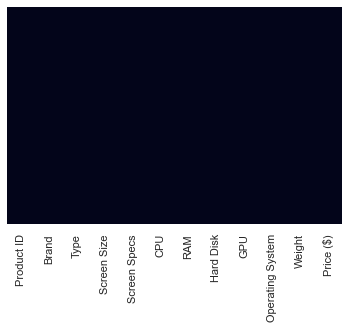

Product ID          0
Brand               0
Type                0
Screen Size         0
Screen Specs        0
CPU                 0
RAM                 0
Hard Disk           0
GPU                 0
Operating System    0
Weight              0
Price ($)           0
dtype: int64

In [8]:
sns.heatmap(pc_EDA.isnull(),yticklabels=False,cbar=False)
plt.show()
# No missing values.
pc_EDA.isnull().sum()

Observations from `Product ID`
- We can see that Product ID has 15320 unique classes, and may simply just be a representation of each row in the dataset.
- Unlikely to provide any value towards our target variable
- Hence dropping it

In [9]:
print(pc_EDA['Product ID'].nunique())

15320


### Target variable analysis
1. Price is very positively skewed to the right, with the existance of outliers. (shown via qqplot and histogram)
2. Posses a high Interquartile range
2. Outliers exist in the form of costly computers of over $10k
3. As mentioned earlier, median will then be used as central tendencies
3. Log transformation can help to convert skewed distribution to a near normal distribution
4. Can also help to treat outliers instead of removing outliers (valuable data).


IQR: 2376.6440000000002


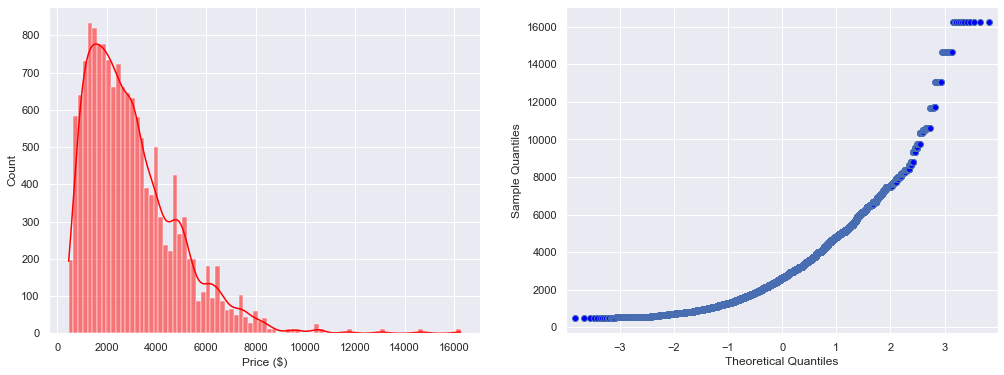

In [10]:
figdist, (axhist, axqq) = plt.subplots(1,2, figsize=(17,6))
# sns.set_context('notebook')
sns.histplot(data=pc_EDA,x='Price ($)',kde=True,color='red',ax=axhist)
qqplot(pc_EDA['Price ($)'],ax=axqq)
figdist.show()
print('IQR:',np.quantile(pc_EDA['Price ($)'], .75) -np.quantile(pc_EDA['Price ($)'],.25)  )
# Most laptops cost around 2k

Attempt to transform target variable
- Price now slightly follows a normal distribution, with majority of the outliers treated.
- This idea might help with the accuracy of the model later on

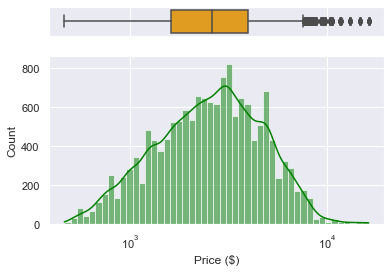

In [11]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

sns.histplot(data=pc_EDA,x='Price ($)',kde=True,color='green',log_scale=True,ax=ax_hist)
sns.boxplot(x=pc_EDA["Price ($)"], ax=ax_box,color='orange')
ax_box.set(xlabel='')
plt.show()
# Log transformation

### Analysing numerical features

We can see that several categorical columns contain a lot of unique categories. For example, CPU has 118 unique classes, GPU has 110. This poses a problem for us as it will be very hard to perform data analysis.
- Moreover, directly applying preprocessing steps like one hot encoding followed by modelling will result in very high cardinality which may result in the curse of cardinality which we do not want.
- However, we can also 'unpack' from features, like specs of GPU/CPU, these features could definitely be of value for the model
- Given this we will perform **data preparation and feature engineering**

In [12]:
# display(pc_EDA['CPU'].head())
for col in pc_EDA.columns:
    print(col,' ',pc_EDA[col].nunique())


Product ID   15320
Brand   19
Type   6
Screen Size   18
Screen Specs   40
CPU   118
RAM   9
Hard Disk   39
GPU   110
Operating System   9
Weight   179
Price ($)   9328


Some attributes have alot of unique values {CPU,Screen specs}

In [13]:
pc_EDA['CPU'].head()
# May be hard to analyse

0          Intel Core i5 2.3GHz
1          Intel Core i5 1.8GHz
2    Intel Core i5 7200U 2.5GHz
3          Intel Core i7 2.7GHz
4          Intel Core i5 3.1GHz
Name: CPU, dtype: object

In [14]:
display(pc_EDA.select_dtypes(exclude=['float64','int64']).describe())

,Brand,Type,Screen Specs,CPU,RAM,Hard Disk,GPU,Operating System,Weight
count,15320,15320,15320,15320,15320,15320,15320,15320,15320
unique,19,6,40,118,9,39,110,9,179
top,Lenovo,Notebook,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows 10,2.2kg
freq,3532,8544,5944,2240,7276,4840,3320,12660,1408


Very large number of unique features for some categorical variables like CPU

> We will also perform EDA on newly created features.

# Feature engineering/splitting
- How did i represent data as features?

| Newly created features | Information  |
| :--- | :--- |
|`CPU brand`| Refers to CPU Manufacturers {Intel, AMD,etc}|
|`Processor clock speed`|Determines how quick the CPU can retrieve and interpret instructions, measured in `GHz` |
|`Pixels (width)`| Screen width in pixels|
|`Pixels (height)`| Screen height in pixels|
|`Touchscreen`|Touchscreen or no? 1- `yes/true` 0- `no/false`|
|`IPS panel`|IPS panel or no? 1- `yes/true` 0- `no/false`|
|`CPU series`|Series of CPU {AMD A, Intel Core i5, Intel Core i7, etc}|
|`SSD`|SSD storage space of a computer in GB, 0 if the computer does not use SSD|
|`HDD`|HDD storage space of a computer in GB, 0 if the computer does not use HDD|
|`Flash`|Flash storage space of PC in GB, 0 if computer does not use Flash storage|
|`Hybrid`|Hybrid storage space of PC in GB, 0 if computer does not use Hybrid storage.|




Converting RAM and Weight to its numerical format, by removing GB and kg respectively
- Generally, the more RAM, the faster the hardware.

> ### Assistance from regex
1. Extracting first string from CPU to form `CPU brand`
2. Extracting the numerical value before `GHz` to form `Processor clock speed`
3. Extracting screen pixel width and height from the resolution format of *`width`*x*`height`* under `Screen Specs`
4. `Touchscreen` shows which computers are touchscreen or not.
5. `IPS Panel` shows which computers are IPS Panel or not.

In [15]:
pc_EDA['RAM'] = pc_EDA['RAM'].str.replace('GB', '').astype(int)
pc_EDA['Weight'] = pc_EDA['Weight'].str.replace('kg', '').astype(float)


# CPU Brand
pc_EDA['CPU brand'] = pc_EDA['CPU'].str.split(' ',expand=True)[0]


# Feature splitting for CPU, Screen Screen specs
pc_EDA['Processor clock speed'] = pc_EDA['CPU'].astype("string").str.extract('([0-9.]+)GHz' ,expand = False).astype(float)


# Resolution is in the form WidthxHeight
pc_EDA[['Pixels (width)', 'Pixels (height)']] = pc_EDA['Screen Specs'].str.extract(r'(\d+)[x](\d+)', expand=True).astype(int)

# 1 for rows with touch screen/ 0 without
pc_EDA['Touchscreen'] = pc_EDA['Screen Specs'].str.contains('Touchscreen', regex=False).astype(int)
pc_EDA['IPS Panel'] = pc_EDA['Screen Specs'].str.contains('IPS', regex=False).astype(int)

> ### Assistance from python re module
1. Use of re.findall/sub to extract CPU series by extensively cleaning `CPU` column
2. CPU has pretty high cardinality, with large amount of unique values. Directly one hot encoding is not ideal, creating excess dimensional spaces.
3. We will extract some useful information from CPU
3. Replacing some duplicate names such as intel M m3 and intel M M3 to similar name.

In [16]:
# CPU cleaning, to extract series
clean1 = np.array(list(map(lambda x: re.findall('.*? \d+',x)[0].strip(), pc_EDA["CPU"] )))

clean2 = np.array(list(map(lambda y: re.sub(" \d+.*", "", y),clean1  )))
clean3 = np.array(list(map(lambda y: re.sub("-[a-zA-Z0-9 ]+", "", y),clean2)))
clean4 =pd.Series( np.array(list(map(lambda l: re.sub(' [Z,E,N][0-9]+', '', l), clean3) )))

clean4 = clean4.str.replace('(A[0-9]+)','')
clean4 = clean4.str.replace('Intel Core M M3','Intel Core M m3')
clean4 = clean4.str.replace('Intel Atom X5','Intel Atom x5')
clean4 = clean4.str.replace('Intel Core M M7', 'Intel Core M m7')
clean4 = clean4.str.replace('Samsung Cortex &', 'Samsung Cortex')
clean4[clean4 == 'AMD '] = clean4[clean4 == 'AMD ']  + 'A'
pc_EDA['CPU Series'] = clean4
display(pc_EDA['CPU Series'].unique())

array(['Intel Core i5', 'Intel Core i7', 'AMD A', 'Intel Core i3',
       'Intel Core M m3', 'Intel Atom x5', 'AMD E',
       'Intel Celeron Dual Core', 'AMD Ryzen', 'Intel Pentium Quad Core',
       'AMD FX', 'Intel Core M', 'Intel Xeon', 'Intel Celeron Quad Core',
       'Intel Atom', 'Intel Pentium Dual Core', 'Intel Core M m7',
       'Samsung Cortex'], dtype=object)

In [17]:
display(pc_EDA['Hard Disk'].unique())
display(pc_EDA['Hard Disk'].nunique())

array(['128GB SSD', '128GB Flash Storage', '256GB SSD', '512GB SSD',
       '500GB HDD', '256GB Flash Storage', '1TB HDD',
       '32GB Flash Storage', '128GB SSD +  1TB HDD',
       '256GB SSD +  256GB SSD', '64GB Flash Storage',
       '256GB SSD +  1TB HDD', '256GB SSD +  2TB HDD', '32GB SSD',
       '2TB HDD', '64GB SSD', '1.0TB Hybrid', '512GB SSD +  1TB HDD',
       '1TB SSD', '256GB SSD +  500GB HDD', '128GB SSD +  2TB HDD',
       '512GB SSD +  512GB SSD', '16GB SSD', '16GB Flash Storage',
       '512GB SSD +  256GB SSD', '512GB SSD +  2TB HDD',
       '64GB Flash Storage +  1TB HDD', '180GB SSD', '1TB HDD +  1TB HDD',
       '32GB HDD', '1TB SSD +  1TB HDD', '512GB Flash Storage',
       '128GB HDD', '240GB SSD', '8GB SSD', '508GB Hybrid', '1.0TB HDD',
       '512GB SSD +  1.0TB Hybrid', '256GB SSD +  1.0TB Hybrid'],
      dtype=object)

39

Upon scrutinizing, we notice that there are some duplicates such as 1.0 TB HDD and 1TB HDD which should be treated the same.
##### Method:
1. Replace all TB with 1000 GB.
2. Create 4 new features by extracting out the storage space, and inputting to its corresponding storage type.
3. For e.g -> A computer will have 128 GB SSD. The storage space representation will look like:

In [18]:
pd.DataFrame([[128,0,0,0]], columns=['SSD', 'HDD', 'Flash', 'Hybrid'])

,SSD,HDD,Flash,Hybrid
0,128,0,0,0


We notice some observations are separated by a `+`, hence we need to take extra precautions while unpacking

In [19]:
pc_EDA['Hard Disk'] = pc_EDA['Hard Disk'].str.replace('.0', '',regex=False).str.replace('TB', '000GB').str.replace(' Storage' , '')
d = {'SSD' : [] , 'HDD' : [] , 'Flash': [] , 'Hybrid'  : []}
def edaCleanse(disk):
    if '+' in disk:
        splitted = list(map(lambda x : x.strip() , disk.split("+") ))
    else:
        splitted = [disk]
    if len(splitted) != 1 and  splitted[0].split(' ')[1] == splitted[1].split(" ")[1]:
        amount1,kind =  splitted[0].split(' ')
        amount2,_ = splitted[1].split(' ')
        d[kind].append(int(amount1.replace('GB' ,'')) + int(amount2.replace('GB' , '')))

    else:
        for drive in splitted:
            amount,kind =  drive.split(' ')
            d[kind].append(int(amount.replace('GB' ,'')))
   
    splitted  = list(map(lambda x : x.split(' ')[1] , splitted))
    for key in filter(lambda x: x not in splitted, d.keys()):

        d[key].append(0)

pc_EDA['Hard Disk'].apply(edaCleanse)
df_concat = pd.DataFrame(d)
pc_EDA=pd.concat([pc_EDA,df_concat],axis=1)

### GPU Type - used to accelerate graphics rendering
- Extract GPU sub category

In [20]:
pc_EDA['GPU type'] = np.array(list(map(lambda d: " ".join(d.split()[0:2]), pc_EDA['GPU'])))
pc_EDA['GPU type'].unique()

array(['Intel Iris', 'Intel HD', 'AMD Radeon', 'Nvidia GeForce',
       'Intel UHD', 'AMD R4', 'Nvidia GTX', 'AMD R17M-M1-70',
       'Nvidia Quadro', 'AMD FirePro', 'Intel Graphics', 'ARM Mali'],
      dtype=object)

In [21]:
gpu = pd.Series(pc_EDA['GPU'])
# Save GPU

Dropping original features that we have processed and unpacked from. We can inspect the shape

In [22]:
pc_EDA.drop(['CPU','Screen Specs', 'Hard Disk'],axis=1,inplace=True)
display(pc_EDA.shape)
pc_df= pc_EDA.copy()
# Make a copy for model later

(15320, 21)

## Exploratory Data Analysis
We will be carrying out data exploration to further understand the characteristics of our data.
- Before building regression model

### Exploring numerical-continuous variables
1. For weight, we can see an uneven distribution with most PCs weighing around 2.2KG.
2. Presence of outliers, with PCs weighing above 4.5kg. 

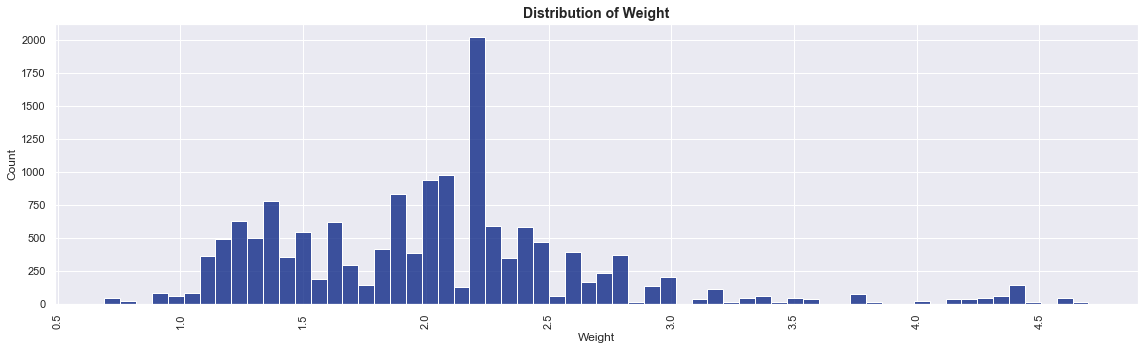

In [23]:
plt.figure(figsize=(16,9))
for o, b in enumerate(['Weight']):
    sns.set_palette(sns.color_palette("dark"))
    axx = plt.subplot(2,1,o+1)
    sns.histplot(x=b, data = pc_EDA, ax = axx)
    sns.set_style('darkgrid')
    plt.xticks(rotation=90)
    axx.set_title(f"Distribution of {b}",fontweight = 'bold', fontsize = 14)
    plt.tight_layout()


Diving deeper, we can see that these PCs are used for gaming which can explain why it is so heavy as compared to other laptops.

In [24]:
pc_EDA[pc_EDA.Weight >4.5].head()

,Product ID,Brand,Type,Screen Size,RAM,GPU,Operating System,Weight,Price ($),CPU brand,...,Pixels (width),Pixels (height),Touchscreen,IPS Panel,CPU Series,SSD,HDD,Flash,Hybrid,GPU type
238,238,Asus,Gaming,17.3,32,Nvidia GeForce GTX 1080,Windows 10,4.7,10362.96000,Intel,...,1920,1080,0,0,Intel Core i7,512,1000,0,0,Nvidia GeForce
577,577,Lenovo,Gaming,17.3,32,Nvidia GeForce GTX 1070,Windows 10,4.6,7094.23200,Intel,...,1920,1080,0,1,Intel Core i7,256,1000,0,0,Nvidia GeForce
1048,1048,Lenovo,Gaming,17.3,16,Nvidia GeForce GTX 980M,Windows 10,4.6,6100.53336,Intel,...,1920,1080,0,1,Intel Core i7,128,1000,0,0,Nvidia GeForce
1081,1081,Lenovo,Gaming,17.3,32,Nvidia GeForce GTX 980M,Windows 10,4.6,8631.36000,Intel,...,1920,1080,0,1,Intel Core i7,512,0,0,1000,Nvidia GeForce
1116,1116,Lenovo,Gaming,17.3,16,Nvidia GeForce GTX 980M,Windows 10,4.6,7325.97336,Intel,...,1920,1080,0,1,Intel Core i7,256,0,0,1000,Nvidia GeForce


## Boxplots

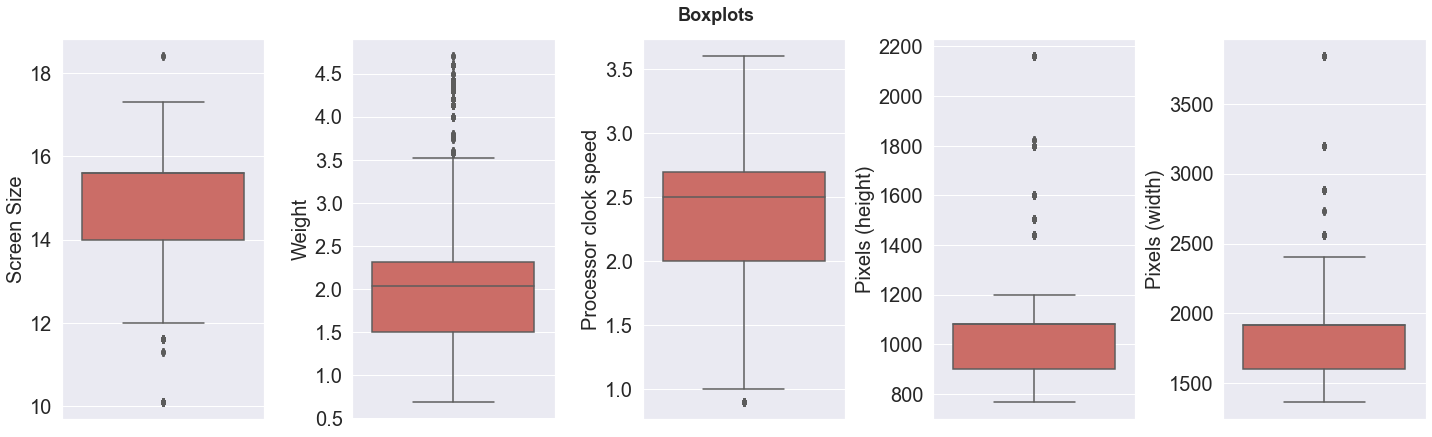

In [25]:
figout, axout = plt.subplots(1, 5, figsize=(20, 6), tight_layout = True)
for i, col in enumerate(['Screen Size','Weight', 'Processor clock speed','Pixels (height)', 'Pixels (width)']):
    axout[i].tick_params(axis='both', which='major', labelsize=20)
    sns.boxplot(data = pc_EDA, y=col, ax = axout[i],palette='hls')
    figout.suptitle("Boxplots",fontweight = 'bold', fontsize = 18)
    axout[i].set_ylabel(col,fontsize=20)
figout.show()

From boxplots:
1. Screensize, processor clock speed generally follows a normal distribution, with barely any outliers.
2. Heaviest PC is close to 5kg, which may suggest gaming PCs as they are generally very heavy
1. Prescense of univariate outliers from ['Weight', 'Pixel']
1. There are generally no extreme outliers.

## Bivariate Analysis

##### From scatter plots:
1. We want to observe if there are any bivariate outliers.
2. Generally there are not many extreme outliers between price and ['Weight', 'Pixels H/W']
3. We note that there is an extreme outlier observed, with 64GB ram, we will investigate this further.
4. Generally most values that are 'outliers' possess a very high price, hence we may be able to utilize Log transformation to help our model later.
5. Several outliers observed under `processor clock speed`, however, they are not very extreme, hence we do not need to worry

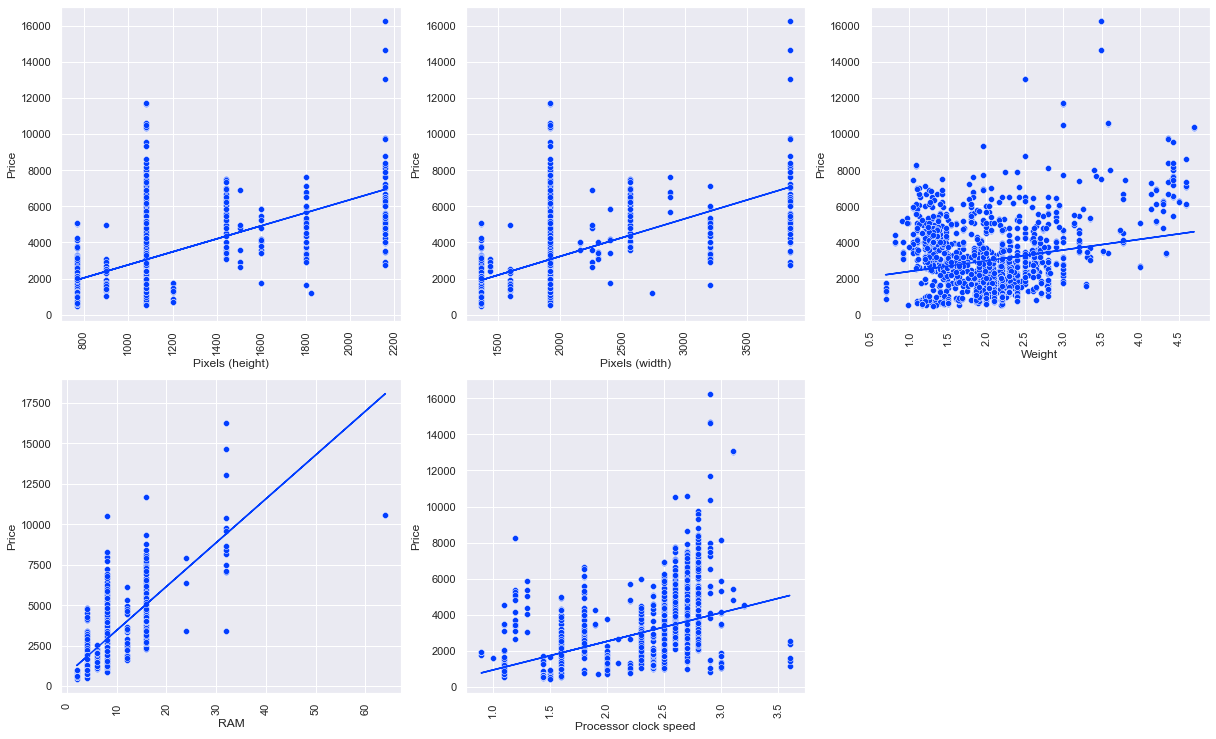

In [26]:
plt.figure(figsize=(17,15))
for i, col in enumerate(['Pixels (height)', 'Pixels (width)' , 'Weight'  ,'RAM', 'Processor clock speed']):
    sns.set_palette(sns.color_palette("bright"))
    ax = plt.subplot(3,3,i+1)
    m,c = np.polyfit(pc_EDA[col],pc_EDA['Price ($)'],1)
    sns.scatterplot(x=col , y = 'Price ($)' , ax = ax , data = pc_EDA )
    ax.plot(pc_EDA[col] ,pc_EDA[col]*m + c  )
    plt.xticks(rotation=90)
    plt.ylabel("Price")
plt.tight_layout()
plt.show()

In [27]:
display(pc_EDA[pc_EDA.RAM >60].head(4))

,Product ID,Brand,Type,Screen Size,RAM,GPU,Operating System,Weight,Price ($),CPU brand,...,Pixels (width),Pixels (height),Touchscreen,IPS Panel,CPU Series,SSD,HDD,Flash,Hybrid,GPU type
1066,1066,Asus,Gaming,17.3,64,Nvidia GeForce GTX 980,Windows 10,3.58,10589.40,Intel,...,1920,1080,0,1,Intel Core i7,1000,0,0,0,Nvidia GeForce
2369,2369,Asus,Gaming,17.3,64,Nvidia GeForce GTX 980,Windows 10,3.58,10599.40,Intel,...,1920,1080,0,1,Intel Core i7,1000,0,0,0,Nvidia GeForce
3593,3593,Asus,Gaming,17.3,64,Nvidia GeForce GTX 980,Windows 10,3.58,10594.57,Intel,...,1920,1080,0,1,Intel Core i7,1000,0,0,0,Nvidia GeForce
4896,4896,Asus,Gaming,17.3,64,Nvidia GeForce GTX 980,Windows 10,3.58,10590.60,Intel,...,1920,1080,0,1,Intel Core i7,1000,0,0,0,Nvidia GeForce


We observe that these are mainly high end PCs, that are running a more expensive GPU, as well as slightly big screen size. We will not drop as these PCs are the only instances of 64GB, dropping them may limit the model to be familiar with such observations in the future during deployment

## Phik (𝜙k) correlation
Phik (𝜙k) is a correlation coefficient that works consistently between numerical, ordinal variables. This is very useful for this current dataset.
- The correlation ranges from 0 to 1, with 0 having no association, while 1 denoting high association

interval columns not set, guessing: ['Screen Size', 'RAM', 'Weight', 'Price ($)', 'Processor clock speed', 'Pixels (width)', 'Pixels (height)', 'Touchscreen', 'IPS Panel', 'SSD', 'HDD', 'Flash', 'Hybrid']


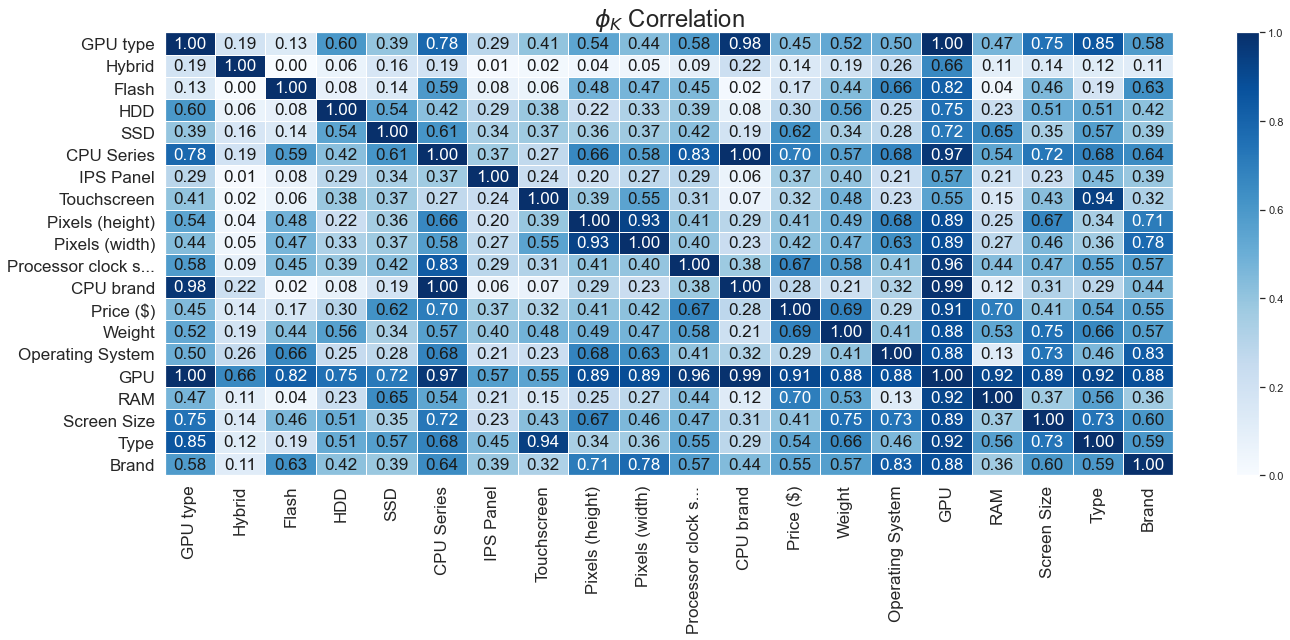

In [28]:
summary = pc_EDA.drop(['Product ID'],axis=1).phik_matrix()
plot_correlation_matrix(summary.values, 
                        x_labels=summary.columns, 
                        y_labels=summary.index, 
                        vmin=0, vmax=1, color_map="Blues", 
                        title=r"$\phi_K$ Correlation", 
                        fontsize_factor=1.7, 
                        figsize=(20, 9))
plt.show()

In [29]:
summary.sort_values(ascending=False, by='Price ($)')['Price ($)'][2:10]

CPU Series               0.704720
RAM                      0.700411
Weight                   0.685608
Processor clock speed    0.672709
SSD                      0.622761
Brand                    0.551036
Type                     0.538901
GPU type                 0.446118
Name: Price ($), dtype: float64

We notice that some features are highly correlated in our model, which may pose a slight problem for our model. 
- Features like pixel width and pixel height are highly correlated. (can consider to drop one)
- May result in an unstable model.
- This may suggest that there are redundant information in the data, and feature selection can be useful and can benefit our model.
- Features like ['Weight', 'RAM', 'CPU Series'] are highly correlated with target variable (price ($) ).
- This is logical as these are the specifications many would look out for in buying a PC. For example, higher RAM(random access memory) may indicate a higher end product, with more efficient processing speeds which are generally more costly.

### Check for multicollinearity between numerical variables through Variance Inflation Factor
- We will check which features suffer most from multicollinearity
- We will evaluate the severity of multicollinearity through measuring the variance inflation factor
- Generally, we will need to pay close attention to features with a VIF above 10.

In [30]:
pc_corr = pc_EDA[['Screen Size', 'Weight', 'Price ($)', 'Processor clock speed', 'Pixels (width)','Pixels (height)']].corr()
inv = np.linalg.inv(pc_corr.values).diagonal()
display(pd.DataFrame({"Variance Inflation Factor":inv}, index=pc_corr.columns).round(1))

,Variance Inflation Factor
Screen Size,3.4
Weight,3.5
Price ($),1.9
Processor clock speed,1.4
Pixels (width),98.5
Pixels (height),98.8


1. Pixels height and width have very high VIF.
2. Numerical features like weight, screen size have generally lesser VIF.

## Comparing price against components/aspects

## General Insights:
1. We will use median as central tendancy due to right skewed prices.
2. Razor is the most expensive brand of PCs, this would be logical as they specialise in high end gaming laptops, with good performances.
3. Generally less well known brands such as Chuwi & Vero costs cheaper.
4. Workstation type PC are most expensive, likely as they are used for high end computers that are used for scientific or any other heavy usage application.
5. MacOS is the most expensive with median price of around 4000.
6. Generally, we can see a direct relationship between RAM and price, with 64GB PCs being the most expensive, while 2GB PCs costing very little. As RAM increases, price increases as well. 
7. Intel brand of cpu costs the most expensive.
8. For CPU sub categories, Intel Xeon is the most expensive category with prices over 10000, perhaps it has top tier and permium in performance, and are usually used by businesses as server class chips.
9. FOr GPU types, Nvidia GTX costs very expensive as well, while the cheapest is AMD R4.
10. Generally, the larger the screen size, the more expensive the price of PC.
11. PCs with touchscreen or IPS Panels generally cost more than without

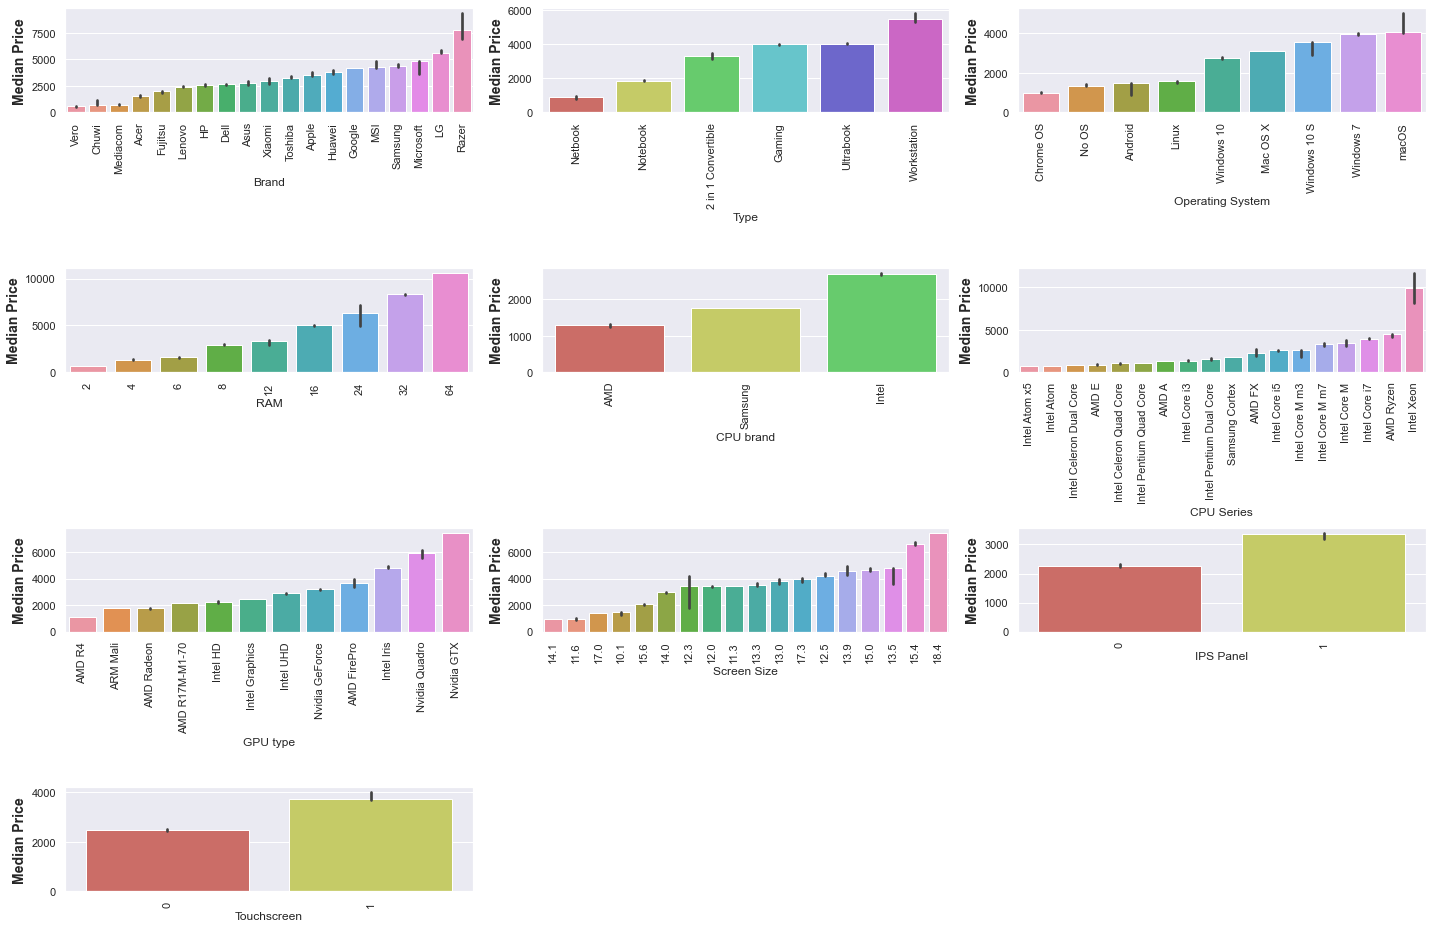

In [31]:
plt.figure(figsize=(20,13))
for i, col in enumerate(['Brand', 'Type', 'Operating System','RAM', 'CPU brand','CPU Series', 'GPU type','Screen Size', 'IPS Panel', 'Touchscreen']):
    sns.set_palette(sns.color_palette("hls"))
    axpr = plt.subplot(4,3,i+1)
    orderby = pc_EDA.groupby(col)['Price ($)'].median().sort_values().index
    # display(orderby)
    sns.barplot(x=col, y ='Price ($)', estimator = np.median, data = pc_EDA, ax = axpr, order=orderby)
    sns.set_style('darkgrid')
    plt.xticks(rotation=90)
    plt.ylabel("Median Price",fontweight = 'bold', fontsize = 14)
    plt.tight_layout()
plt.show()

## Exploring general features

#### Key observations:
- In constrast to the previous plot, we note that the most expensive one is not always the most common. From the data, there are very little PCs with 64GB, which may explain the exorbitant costs. Similar with Intel Xeon.
- This may be because the PC website may generally cater to general public, hence such specialised components may not listed, hence may be more uncommon, which explains the low counts.
- More common CPU sub categories or components like Intel Core i7 are listed, as well as common OS like Win10. 
- Less touchscreens and IPS panels PCs
- For brand, there are several categories with very low counts.

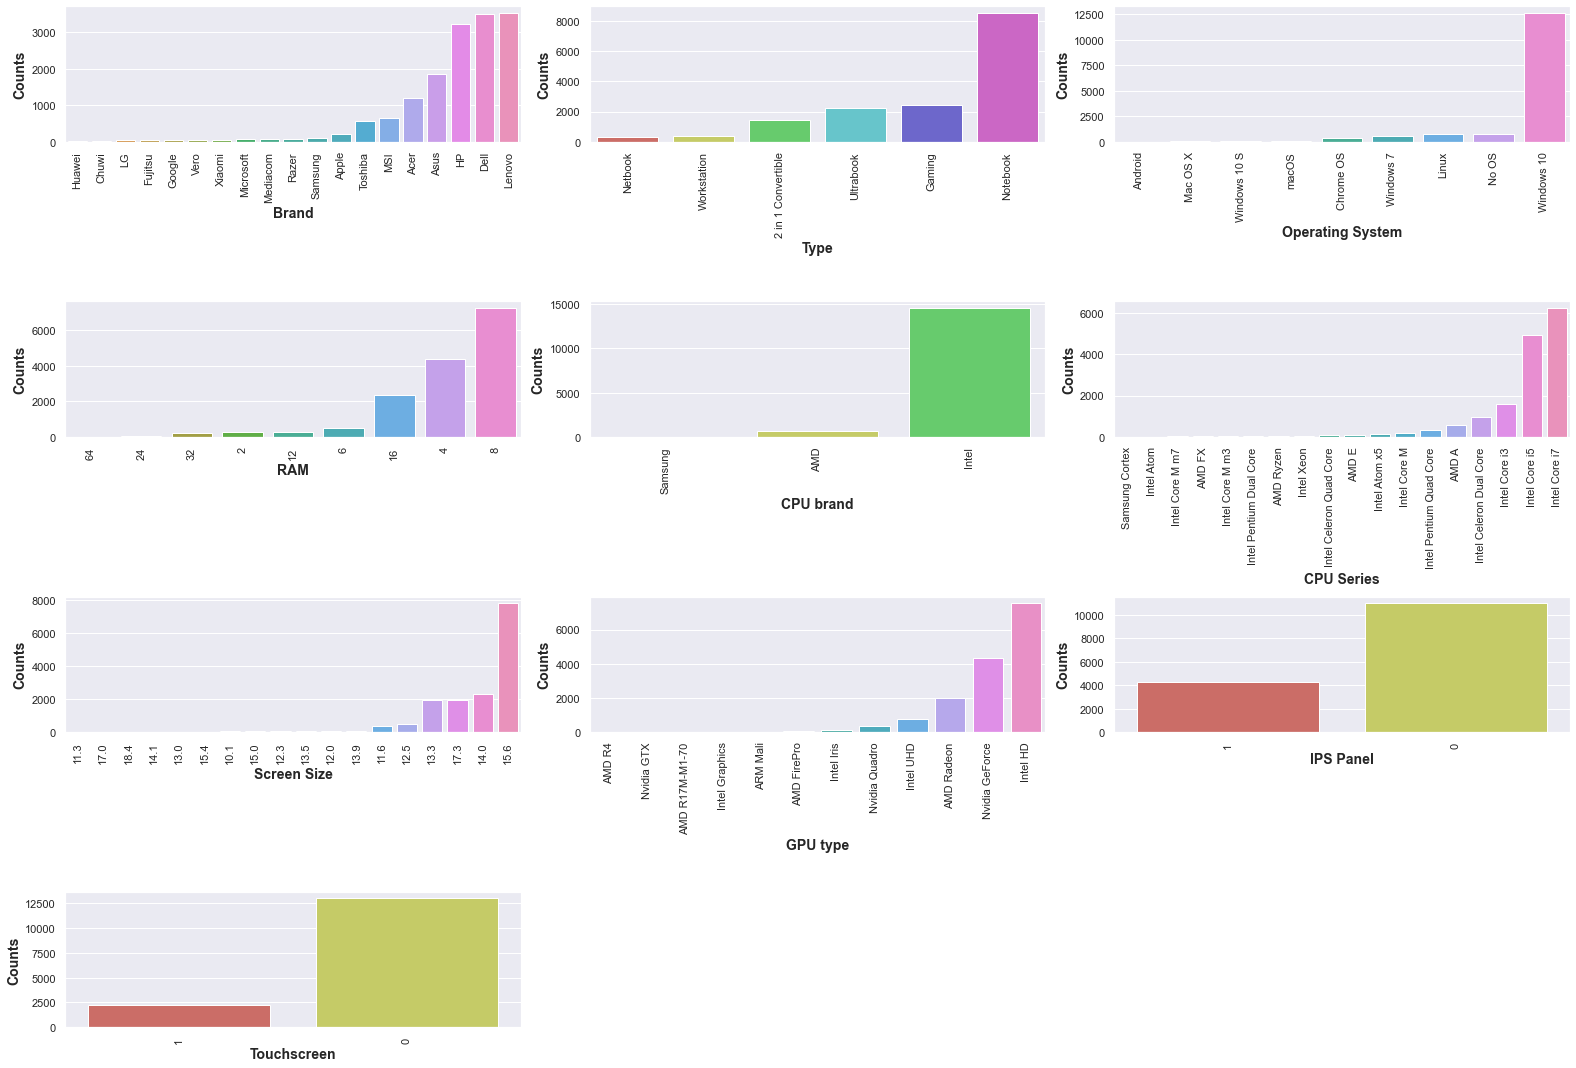

In [32]:
plt.figure(figsize = (22,15))
for y, f in enumerate(['Brand', 'Type', 'Operating System','RAM', 'CPU brand', 'CPU Series', 'Screen Size','GPU type','IPS Panel', 'Touchscreen']):
    axc = plt.subplot(4,3,y+1)
    order2 = pc_EDA[f].value_counts().sort_values()
    sns.barplot(x=order2.index, y=order2, ax =axc,order=order2.index)
    plt.xlabel(f, fontweight = 'bold', fontsize = 14)
    plt.ylabel(f'Counts', fontweight = 'bold', fontsize = 14)
    plt.tight_layout()
    plt.xticks(rotation=90)

In [33]:
# plt.figure(figsize=(16,9))
# for o, b in enumerate(['Brand', 'Type', 'Operating System','CPU Series','GPU type','Screen Size']):
#     sns.set_palette(sns.color_palette("tab10"))
#     axx = plt.subplot(3,3,o+1)
#     orderby2 = pc_EDA.groupby(b)['Price ($)'].median().sort_values().index
#     sns.boxplot(x=b, y ='Price ($)', data = pc_EDA, ax = axx,order=orderby2,linewidth = 1.2,flierprops = dict(marker = 'o', markersize = 2.5, linestyle = 'none', markerfacecolor = 'red', alpha = 0.75))
#     sns.set_style('darkgrid')
#     plt.xticks(rotation=90)
#     plt.ylabel("Price",fontweight = 'bold', fontsize = 14)
#     plt.tight_layout()

# Preprocessing

## Performing the same feature engineering on main dataframe
- We will retain the original GPU column for our model training, as it could lead to information loss.
- Dropping the previous GPU type column

In [34]:
pc_df['GPU'] = gpu
pc_df.drop('GPU type',axis=1,inplace=True)

## Drop product ID

1. We will drop `Product ID` column as it does not properly provide information towards target variable price, and more of a unique representation of each row.

In [35]:
pc_df.drop('Product ID', axis=1,inplace=True)

### Separating target label from features.

In [36]:
X ,y = pc_df.drop(['Price ($)'],axis=1), pc_df['Price ($)']

# Creating hold out sets
1. Create training and independant testing sets for final evaluation later on
2. Perform KFold Cross validation on train set for model selection.
3. Use of train test split such that the training set has **no** idea about the test set
4. Test set is used as an unseen set, to have a last and crucial evaluation of the utility of final model
5. **It is only when the model comes across data it has not seen before, then we can really determine how good the model generalizes.**

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,random_state =rstate)

As a general rule `.fit()` will not be called on test set to prevent data leakage 

## Model Evaluation Metrics

To aid our model selection, we will be using some regression metrics to evaluate the model.
1. We can try other metrics such as MAE, MSE, where MSE penalizes larger errors by `squaring` the error, and MAE do not really penalize the model for making large errors.
2. We will be using Root Mean squared error as our main metric to evaluate regression models as it is simpler to understand, and also due to the reasons below:

$$\mathrm{RMSE} = \sqrt{\frac{\sum_{i=1}^{N}\left(y_{i}-\hat{y}_{i}\right)^{2}}{N}}$$
where *N* = no. of data observations, $y_{i}$ is actual value, while $\hat{y}_{i}$ is the predicted value

Since our aim is to predict computer prices, RMSE is better in terms of reflecting model performance in dealing with outliers/ large error values. RMSE tell us how accurate our predictions are and, the amount of deviation from the actual values.
>**Moreover, since our goal is to predict computer prices accurately for potential PC buyers who may not be familiar with the market price, we want to be penalized due to large errors made by the model. This is to ensure that our final model is very robust and accurate. Ultimately, we do not want our model to predict prices that are very far off/inaccurate, causing potential PC buyers to overspend**

# Further preprocessing data using a pipeline to prevent data leakage (during CV).
- Use of `CustomHandleFeatures` class to select our features, and passing through numerical and categorical variables through different preprocessing steps, through `FeatureUnion`
- Since, numerical variables are of different scales, we will use of `StandardScaler()` to standardize values.
- Perform `One Hot Encoding` on categorical features as they are nominal in nature and have no clear hierarchy among the different categories, set `drop = 'first'` to prevent highly correlated encoded features.

In [38]:
class CustomHandleFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, names=None):
        self.names = names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.names]
    # def get_feature_names(self):
    #     return self.names

numeric_cols = ['Touchscreen', 'IPS Panel','Weight', 'Screen Size', 'RAM', 'Pixels (width)', 'Pixels (height)', 'Processor clock speed', 'SSD', 'HDD', 'Flash', 'Hybrid']
cat_cols = ['CPU brand','CPU Series','Brand', 'Type', 'Operating System', 'GPU']
preprocess = Pipeline([
    ("features", FeatureUnion([
        ('numeric', make_pipeline(CustomHandleFeatures(names=numeric_cols),StandardScaler() )),
        ('categorical', make_pipeline(CustomHandleFeatures(names=cat_cols),OneHotEncoder(handle_unknown='ignore',sparse=False,drop='first')))
    ]))
])

## Modelling

Ultimately, we want to pick a useful yet robust model that helps us understand how the features relate to the target variable (feature importances), at the same time possessing a low RMSE.
- Use of KFold Cross validation to select our best models. 
>### KFold Cross Validation:
1. By setting k∈ ${\mathbb {Z^+}}$, in this case for example: k=5, we will partition the training set into 5 different folds, 4 of them will be used for model training (fit), while last fold (test set) is used for evaluation/prediction, and computation of metrics. This process is repeated for 5 times, with a set `previously` from the train set, swapped as the test set in each split. Eventually, all 5 folds will be in the place of a test set once.
- Scores are recorded for each split.


In [39]:
rmse = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

# Model Selection
> We will use the functions below to evaluate bias and variances of models, and also scrutinize cross validation results
1. We will first plot a learning curve for each model, for the purpose of analysing how well it performs (overfitting/undefitting)
2. KFoldCV using `cross_validate`
2. We will then observe a few metrics such as MAPE, RMSE and $R^2$ to select best model

In [40]:
# Function to show cross validation scores for the model purpose is to evaluate model performance
# Cross validate and displays the scores for different metrics on the TRAIN set
def evaluateReg(model,X_train,y_train,name):
    rmse = make_scorer(mean_squared_error, greater_is_better=False, squared=False)
    scoring = {
        'MSE':'neg_mean_squared_error',
        'r2':'r2',
        'MAPE':'neg_mean_absolute_percentage_error',
        'RMSE': rmse
    }
    scores = cross_validate(model, X_train, y_train, cv = KFold(n_splits = 5, shuffle = True,random_state=rstate), scoring = 
    scoring, return_train_score = True, return_estimator = True, n_jobs= -1)
    scores = pd.DataFrame(scores).append(pd.DataFrame(scores).describe().loc[['mean','max']]).drop(['fit_time', 'score_time'],axis=1).round(4)
    scores['estimator']= name
    return pd.DataFrame(scores)

    
def model_evaluation(models, X_train, y_train, cv = 5):
    hist = {}
    for idx, model in enumerate(models):
        model_name = re.findall('[^()]+', str(model.named_steps['Model']))[0]
        # print(model_name)
        cv_hist = evaluateReg(model,X_train,y_train,model_name)
        ax = plt.subplot(3,3,idx+1)
        # performance in a dict
        hist[model_name] = dict(
            cv_mape = cv_hist['test_MAPE'].mean(),
            cv_rmse = cv_hist['test_RMSE'].mean(),
            train_rmse = cv_hist['train_RMSE'].mean(),
            cv_std_rmse = cv_hist['test_RMSE'].std(),
            cv_r2 = cv_hist['test_r2'].mean()
        )
        train_sizes, train_scores, test_scores= learning_curve(
                model,
                X_train,
                y_train,
                cv=KFold(n_splits=cv,shuffle=True),
                n_jobs=-1,
                train_sizes = np.linspace(0.01, 1, 20),
            scoring= rmse
        )

        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        
        sns.lineplot(x=train_sizes ,y =train_scores_mean ,ax=ax,label=str('Train Scores') )
        sns.lineplot(x = train_sizes ,y = test_scores_mean,ax=ax,label=str('Test Scores'))
        plt.rc('font', size=14)
        plt.rc('axes', labelsize=14, titlesize=14)
        plt.rc('legend', fontsize=14)
        plt.rc('xtick', labelsize=10)
        plt.rc('ytick', labelsize=10)
        if idx ==0 or idx == 3 or idx ==6:
            plt.ylabel(f"Root Mean Squared Error")
        plt.xlabel("Train Sizes")
        plt.title(re.findall('[^()]+', str(model.named_steps['Model']))[0])
        
        ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                            train_scores_mean + train_scores_std, alpha=0.1,
                            color="r")
        ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                            test_scores_mean + test_scores_std, alpha=0.1, color="g")
        plt.tight_layout()
        # ax.legend(loc='best')
        # plt.show()
    display(pd.DataFrame(hist))
    return pd.DataFrame(hist)

# Models
>### 1. Stupid Baseline Model
- Used to compare with other models
- Served as a reference point/low benchmark for our model selection
- Always predicts the median of the training set (`strategy = median`), this is because the target variable is right skewed, hence as mentioned earlier, median is a better central tendancy
> ### 2. Ridge & Lasso & KNR, ensembles/trees
- Perform scaling, and handling categorical features.
> ### 3. SVR
- Use of Linear Kernel and default $C$ value

In [41]:
dummy = Pipeline([
    ('preprocess', preprocess),
    ('Model', DummyRegressor(strategy='median'))
])
ridreg = Pipeline([
    ('preprocess', preprocess),
    ('Model', Ridge())
])
knr = Pipeline([
    ('preprocess', preprocess),
    ('Model', KNeighborsRegressor())
])
dectreereg =  Pipeline([
    ('preprocess', preprocess),
    ('Model', DecisionTreeRegressor(random_state=rstate))
])
svm = Pipeline([
    ('preprocess', preprocess),
    ('Model', SVR(kernel='linear'))
])
lasso = Pipeline([
    ('preprocess', preprocess),
    ('Model', Lasso())
])
gbr = Pipeline([
    ('preprocess', preprocess),
    ('Model', GradientBoostingRegressor(random_state=rstate))
])
rf = Pipeline([
    ('preprocess', preprocess),
    ('Model', RandomForestRegressor(random_state=rstate))
])

#### We will now compare the different models.
- After cross validation, I have compiled the mean for each metric on the CV sets for each regression model

,DummyRegressor,Lasso,Ridge,SVR,KNeighborsRegressor,DecisionTreeRegressor,GradientBoostingRegressor,RandomForestRegressor
cv_mape,-0.611886,-0.194014,-0.183843,-0.208300,-0.010371,-0.006486,-0.162757,-0.007014
cv_rmse,-1896.413671,-705.268257,-672.735514,-939.269543,-84.279586,-58.004000,-567.472514,-58.595171
train_rmse,-1904.248929,-697.114957,-667.201757,-940.827300,-65.556057,-53.652014,-561.459886,-54.098743
cv_std_rmse,49.915645,16.098043,11.931494,18.950212,6.561158,3.500174,17.918306,2.812454
cv_r2,-0.043086,0.857000,0.869886,0.746471,0.997957,0.999029,0.908271,0.999000


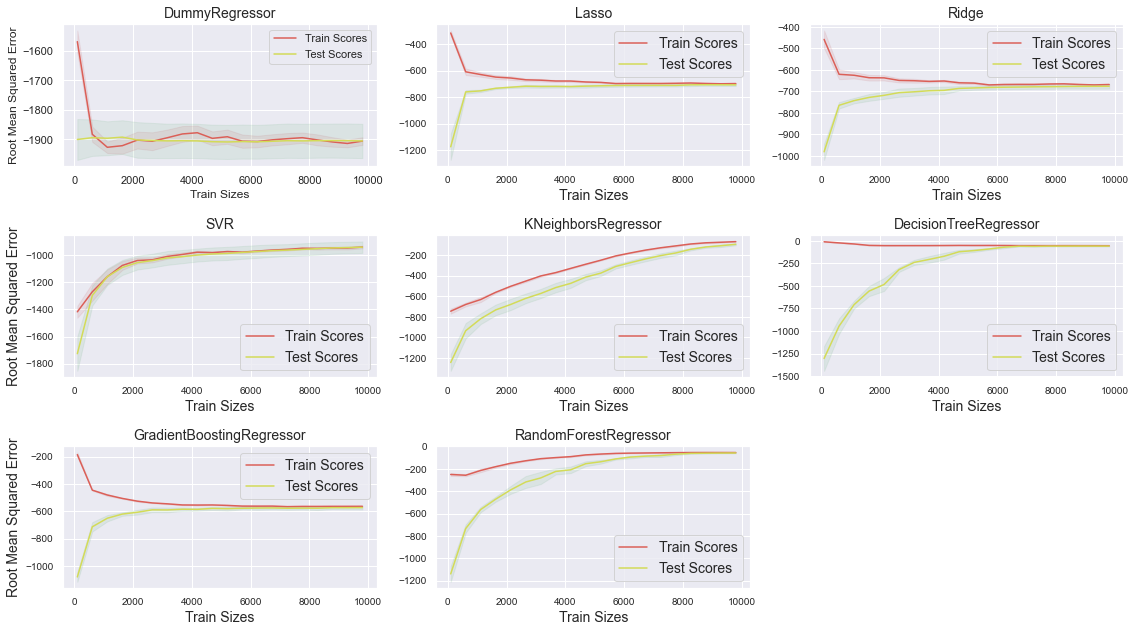

In [42]:
plt.figure(figsize=(16,9))
scores_final = model_evaluation([dummy, lasso,ridreg,svm,knr,dectreereg,gbr,rf],X_train,y_train)

### After training the models and scrutinizing the outcomes, we can note several observations
>### 1. Stupid Baseline Model
- The stupid baseline model (dummy regressor) does not do well at all with a horrible RMSE. It is also severely underfitting.
> ### 2. Linear Models
- `Lasso` and `Ridge` regression generally do not overfit, and have pretty low variance given the small difference in CV and train scores.
- They do however underfit as they may not be complex enough and generally performs poorly
- These models pale in comparison to `ensemble` models or like `Decision Trees` in terms of RMSE
> One possible improvement is to introduce `PolynomialFeatures()` which generate polynomial and interaction features

> ### 3. Distance based models
- `KNeighborsRegressor` might be suffering from slight underfitting, and has a decent average RMSE score
- Slightly overfitting given the larger difference in errors in CV and training sets
- Generally performs better than the linear models
> One improvement approach to take could be changing the scalers

> ### 4. Tree models
- `DecisionTreeRegressor` performs exceptionally well, possessing a low bias and variance, given its similar train and CV scores.
- Does not seem to be overfitting, hence we can consider this to be our model
- Possess excellent $RMSE$ scores (lowest) for train and CV.
> One improvement could be further tuning model by optimizing hyperparameters

> ### 5. SVM
- Possess similar train and CV scores
- Generally does not perform well with high $RMSE$, though it has low variance.
- Suffers from high bias, indicated by the high errors from train and CV scores.
> One improvement is to select the regularization parameter $C$, 

> ### 6. Ensembles
- `Gradient Boosting` and `Random forests` perform very well, suffering from slight overfitting.
- RandomForest posses low biases, indicated by low errors from CV sets.
- Gradient boosting generally have pretty high bias, which seems like it is underfitting.
> One improvement approach to take is to tune hyper parameters, such as `max_depth` or `learning_rate` for gradient boostings.

## Evaluating models

In [43]:
display(scores_final.T)

,cv_mape,cv_rmse,train_rmse,cv_std_rmse,cv_r2
DummyRegressor,-0.611886,-1896.413671,-1904.248929,49.915645,-0.043086
Lasso,-0.194014,-705.268257,-697.114957,16.098043,0.857000
Ridge,-0.183843,-672.735514,-667.201757,11.931494,0.869886
SVR,-0.208300,-939.269543,-940.827300,18.950212,0.746471
KNeighborsRegressor,-0.010371,-84.279586,-65.556057,6.561158,0.997957
DecisionTreeRegressor,-0.006486,-58.004000,-53.652014,3.500174,0.999029
GradientBoostingRegressor,-0.162757,-567.472514,-561.459886,17.918306,0.908271
RandomForestRegressor,-0.007014,-58.595171,-54.098743,2.812454,0.999000


**Evaluation:**
1. Generally, Decision Trees performed the best with a lowest mean absolute percentage error, as well as lowest $RMSE$.
2. Does not overfit like distanced based models, and hits the sweet spot.
2. Even outperformed models like Random Forests in terms of cross validation scores.
> 4. To summarise, Decision trees is a promising candidate, and we will use this model.

# Model Improvement

Utility function: Validation curve function to be plotted

In [44]:
def plot_vc(model, X_train, y_train, param_name, param_range,ax):
  train_scores, test_scores = validation_curve(model, X_train, y_train,cv=KFold(shuffle=True,random_state = rstate,n_splits=3), param_name = param_name, param_range = param_range, scoring=rmse, n_jobs = -1)
  sns.lineplot(x=np.tile(param_range, train_scores.shape[1]), y=train_scores.flatten(), ax = ax, label = 'Train Scores')
  sns.lineplot(x=np.tile(param_range, test_scores.shape[1]), y=test_scores.flatten(), ax = ax,label = 'CV Scores')
  ax.set_title(f"V. Curve ({param_name})")
  ax.set_ylabel("RMSE")
  ax.set_xlabel(f"{param_name}")

### Log transformation on target variable

Price has a follows a highly positively skewed distribution. Skewness, which indicates the lack of symmetry in data, could adversely affect regression model.
- Log transformation can help ease the skewness, as well as enable the model to be more robust, by transforming target variable to follow a normal distribution
- We will evaluate this decision, whether it improves our model

$$ X_{Transform} = log(X)$$
- Use of sklearn `TransformedTargetRegressor`, to apply log transformation. Use of np.log so that target variable follows a normal distribution

,TransformedTargetRegressor
cv_mape,-0.006471
cv_r2,0.999086
cv_rmse,-56.427500
cv_std_rmse,3.187230
train_rmse,-53.922414


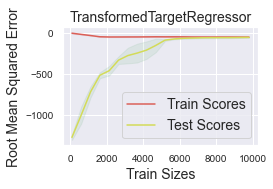

In [45]:
logmodel = Pipeline([
('preprocess', preprocess),
('Model', TransformedTargetRegressor(DecisionTreeRegressor(random_state=rstate), func=np.log,inverse_func=np.exp) )
])
plt.subplots(figsize=(10,7))
log_score = model_evaluation([logmodel],X_train,y_train)

Generally performs slightly better, after using `TransformedTargetRegressor`, more importantly, it has lowered the variance for the model.

## Feature Selection
1. As seen from correlation matrix, several features are highly correlated, which may pose a problem for the model, suggesting redundant features. 
1. Next, we will try to reduce features by performing Feature Selection on our data, with the goal of removing less relevant features from the data, to avoid our models overfitting to noise as well as attaining a simpler model.
3. We can try a few methods such as `PCA` or filter based feature selection like `SelectKBest` or `RFE`.

## PCA

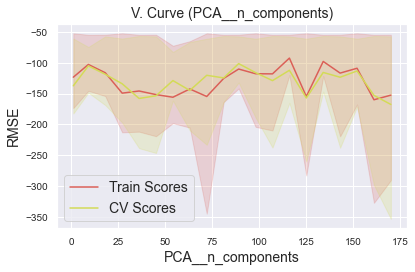

In [65]:
model_pca= Pipeline([
('preprocess', preprocess),
('PCA', PCA(random_state = rstate ) ),
('Model', TransformedTargetRegressor(DecisionTreeRegressor(random_state=rstate), func=np.log,inverse_func=np.exp) )
])

plot_vc(model_pca,X_train,y_train,'PCA__n_components',np.linspace(1, 170  , 10 , dtype = int ) ,plt.gca())

plt.tight_layout() 
plt.show() 

1. From the Validation Curve, we note that changing `n_components` brings about a volatile trend, and also having a slightly higher RMSE, than we have seen. This may not be very ideal for our model.

## Recursive Feature Elimination
- Wrapper type algorithm that select features that are the most relevant in predicting target variable, which can be more efficient than a filter based feature selection method.
- Works by searching for a subset of features by starting with everything in the training set and slowly removing features until the number we specify.
- We recognize that since we are one hot encoding our categorical variables, and since the dimension of the input space increases with the cardinality of our encoded variable, we may face a problem of the curse of dimensionality where excessive dimensional spaces are created, which may be result in overfitting hence not generalizing well to new examples. This highlights the need of RFE

![alt text](https://miro.medium.com/max/1400/1*pcJdd2y924Xk61SXa7uYpw.jpeg "Title")

Our problem is that some of our categorical variables have very large number of unique values, encoding will result to excessive dimensional spaces, which will hinder performances.

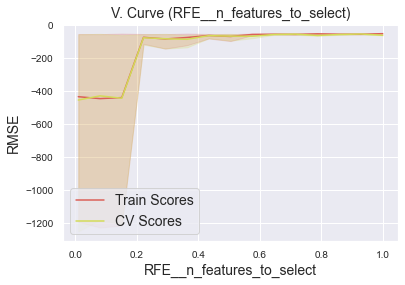

In [46]:
# Plot validation curve to select best RFE
decision_tree_rfe = Pipeline([
('preprocess', preprocess),
('RFE', RFE(DecisionTreeRegressor(random_state=rstate))),
('Model', TransformedTargetRegressor(DecisionTreeRegressor(random_state=rstate), func=np.log,inverse_func=np.exp) )
])

plot_vc(decision_tree_rfe ,X_train, y_train ,'RFE__n_features_to_select',np.linspace(0.01, 1 , 15 , dtype = float),plt.gca())
plt.show() 

We note that percentage of features to select is around .4 which is most optimal and is the sweet spot.

,TransformedTargetRegressor
cv_mape,-0.006514
cv_r2,0.999043
cv_rmse,-57.299629
cv_std_rmse,4.389523
train_rmse,-53.769971


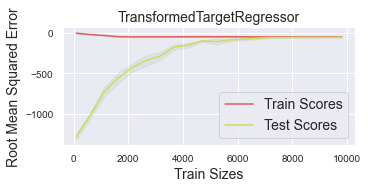

In [47]:
model = Pipeline([
    ('preprocess', preprocess),
    ('RFE', RFE(DecisionTreeRegressor(random_state=rstate),n_features_to_select=0.4,verbose=4,step=1)),
    ('Model', TransformedTargetRegressor(DecisionTreeRegressor(random_state=rstate), func=np.log,inverse_func=np.exp) )
])
plt.subplots(figsize=(14,7))
rfe_score = model_evaluation([model],X_train,y_train)

1. We will pass `RFE` into the pipeline to prevent data leakage
2. Specifying `n_features_to_select` parameter in `RFE`
3. We will keep 40% of the features

## Feature Engineering
### Pixels per inch as a feature - refers to individual pixels are displayed in one inch of a digital image
$$PPI =  \frac{\sqrt{Width^2 + Height^2 }}{Screen Size}$$
- PPI can represent display resolution

In [48]:
class PixelsPerInch(BaseEstimator,TransformerMixin):
    def __init__(self,col1,col2,col3):
        self.col1 = col1
        self.col2 = col2
        self.col3 = col3
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        # Create new features
        X_ = X.copy()
        X_['ppi'] = np.sqrt((X_[self.col1] ** 2 ) + (X_[self.col2] ** 2) )/ X_[self.col3]
        return X_
preprocess2 = Pipeline([
    ("features", FeatureUnion([
        ('numeric', make_pipeline(CustomHandleFeatures(names=numeric_cols + ['ppi']),StandardScaler() )),
        ('categorical', make_pipeline(CustomHandleFeatures(names=cat_cols),OneHotEncoder(handle_unknown='ignore',sparse=False,drop='first')))
    ]))
])
model_ppi = Pipeline([
    ('ppi', PixelsPerInch(col1 ='Pixels (width)',col2 ='Pixels (height)', col3 = 'Screen Size'  )),
    ('preprocess', preprocess2),
    ('RFE', RFE(DecisionTreeRegressor(random_state=rstate),n_features_to_select=0.4,verbose=4,step=1)),
    ('Model', TransformedTargetRegressor(DecisionTreeRegressor(random_state=rstate),func=np.log,inverse_func=np.exp) )
])

,TransformedTargetRegressor
cv_mape,-0.006657
cv_r2,0.999014
cv_rmse,-57.755386
cv_std_rmse,2.108987
train_rmse,-54.150257


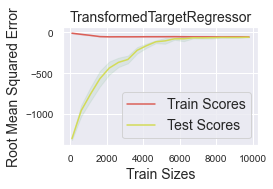

In [59]:
plt.subplots(figsize=(10,7))
ppi_score = model_evaluation([model_ppi],X_train,y_train)

Introducing this as a feature has maintained the variance.

>## Introducing other approaches used for feature scaling
- We can explore several methods that can help us with our model.
- We will attempt to scale our model using different scalers, with the idea to improve it
- Make sure that feature of higher magnitude will not 'control' the model
<!-- - Standard scaler/Robust seems to be the better ones. -->

In [50]:
d = pd.DataFrame()
scalers = {'Power':PowerTransformer(),'Standard':StandardScaler(),"Robust": RobustScaler(), 'MinMax':MinMaxScaler()}
for model in [TransformedTargetRegressor(DecisionTreeRegressor(random_state=rstate), func=np.log,inverse_func=np.exp)]:
  for i,scaling in enumerate(scalers.values()):
    prep = Pipeline([
        ("features", FeatureUnion([
            ('numeric', make_pipeline(CustomHandleFeatures(names=numeric_cols),scaling )),
            ('categorical', make_pipeline(CustomHandleFeatures(names=cat_cols),OneHotEncoder(handle_unknown='ignore',sparse=False,drop='first')))
        ]))
    ])
    compare_pipe = Pipeline([
                    ('preprocess', prep),
                    ("Model", model)
    ])
    scores_df = evaluateReg(compare_pipe, X_train, y_train,name=type(model).__name__ + list(scalers)[i] )
    d = d.append(scores_df.T['mean'],ignore_index=True)
display(d)

,estimator,test_MSE,train_MSE,test_r2,train_r2,test_MAPE,train_MAPE,test_RMSE,train_RMSE
0,TransformedTargetRegressorPower,-3356.6535,-3052.6877,0.9990,0.9991,-0.0067,-0.0062,-57.8995,-55.2478
1,TransformedTargetRegressorStandard,-3266.7880,-2920.3237,0.9991,0.9992,-0.0066,-0.0060,-57.1403,-54.0391
2,TransformedTargetRegressorRobust,-5175.6860,-2913.6109,0.9985,0.9992,-0.0069,-0.0060,-68.6245,-53.9729
3,TransformedTargetRegressorMinMax,-3362.7541,-2910.5763,0.9990,0.9992,-0.0066,-0.0060,-57.8950,-53.9430


There is not much difference, hence we will keep our current `StandardScaler()`.

### Final Pipeline

In [71]:
dc_final = Pipeline([
    ('ppi', PixelsPerInch(col1 ='Pixels (width)',col2 ='Pixels (height)', col3 = 'Screen Size'  )),
    ('preprocess', preprocess2),
    ('RFE', RFE(DecisionTreeRegressor(random_state=rstate),n_features_to_select=0.4,step=1)),
    ('Model', TransformedTargetRegressor(DecisionTreeRegressor(random_state=rstate), func=np.log,inverse_func=np.exp) )
])

# Model Evaluation
### Plotting Validation Curve
1. We will plot validation curves and see how the model fares under a range of hyperparameters.
2. Similarly, we will check the validity of hyperparameters.
2. All evaluation is done by TRAIN set.
3. So that we know which range for the hyperparameters in gridsearchcv

In [52]:
# plot validation curve
# Clone
val_dc = clone(dc_final)
param_copy = {
    "Model__regressor__max_features" : [5,8,10,12,15,20],
    "Model__regressor__max_depth" : [20,24,28],
    "Model__regressor__min_samples_split" : np.arange(0,4),
    "Model__regressor__ccp_alpha" : [0, 0.05,0.1,0.015]
}

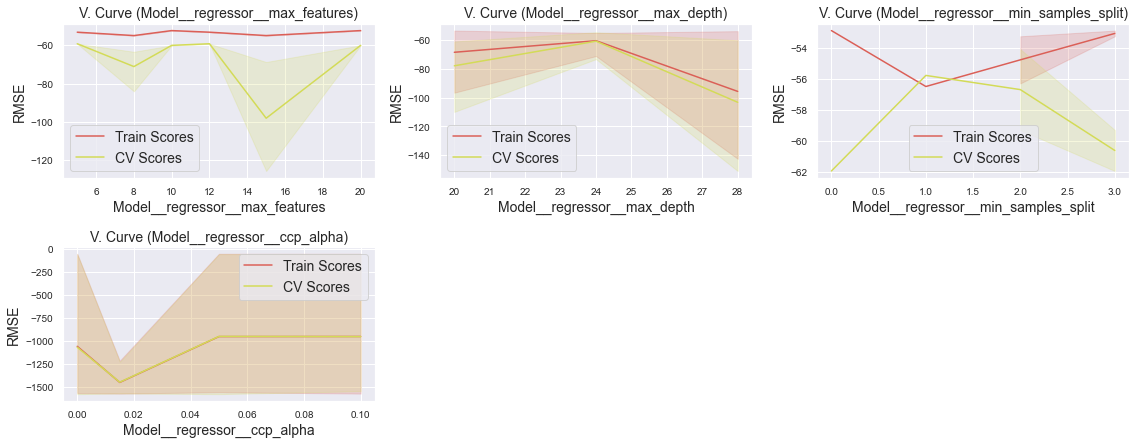

In [62]:
plt.figure(figsize=(16,9))

for i,paramname in zip(range(len(param_copy)), param_copy):
    ax = plt.subplot(3,3,i+1)
    plot_vc(val_dc,X_train,y_train, f'{paramname}',param_copy[paramname],ax )
plt.tight_layout()

From the `validation curves`, we note that the max depth hyperparameter is pretty consistent, with no sudden direction change. From here we can see that max depth is a pretty reasonable hyperparameter. 
- `ccp_alpha` refers to cost complexity pruning

## Analysis of hyperparameters:
max_features | max_depth| min_samples_split | ccp_alpha
:-------------------|:---------------|:---------------|:---------------
CV scores shows a decent range, we will try range [10,20] | Seems to be consistent, can try increase abit more or in same range, dont increase too much else overfit| Seems to be a valid hyperparameter, and in the right range | Can try increase ccp_alpha or leave pruning out.

## Hyperparameter tuning

### Hyperparameter tuning motivation:
max_features | max_depth| min_samples_split | ccp_alpha
:-------------------|:---------------|:---------------|:---------------
Features to consider when looking for the best split|Maximum depth of the tree which is also used to handle overfitting. | Number of samples required to split a node | The pruning used for trees to handle overfitting

1. We will now tune hyperparameters with the goal of trying to simplify our model,
2. Tuning of `max_depth` hyperparameter so as to decide on the optimal depth 

In [54]:
params = {
    "Model__regressor__max_features" : [10,15,20],
    "Model__regressor__max_depth" : [30,32,34,28],
    "Model__regressor__min_samples_split" : np.arange(0,4),
    "Model__regressor__random_state": [rstate],
    "Model__regressor__ccp_alpha" : [0, 0.1,0.2]
}
# gscv scoring is rmse
grid = GridSearchCV(dc_final, params,cv =5 ,n_jobs=-1,scoring=rmse,return_train_score=True)

def gridFit(gridsearch):
    gridsearch.fit(X_train, y_train)
    print('Best params: %s' % gridsearch.best_params_)
    
    return gridsearch

fitted_grid = gridFit(grid)

Best params: {'Model__regressor__ccp_alpha': 0, 'Model__regressor__max_depth': 30, 'Model__regressor__max_features': 20, 'Model__regressor__min_samples_split': 3, 'Model__regressor__random_state': RandomState(MT19937) at 0x28DF47A5540}


## Final Evaluation:
1. Decision Tree Regressor will be our final model
2. With most optimal hyperparameters we will now evaluate model on an unseen test set.
1. To investigate errors made by model, we will visualise a residual plot.
3. We note that our model does not severely underfit, producing a good $RMSE$.
4. Through this, we can conclude that the model is able to generalize well to new examples.

,RMSE,MSE,MAPE
0,53.913662,2906.682917,0.005533


Root mean squared error:  53.913661687467076
Mean squared error:  2906.682916550655
Mean Absolute percentage error: 0.005532789875165795


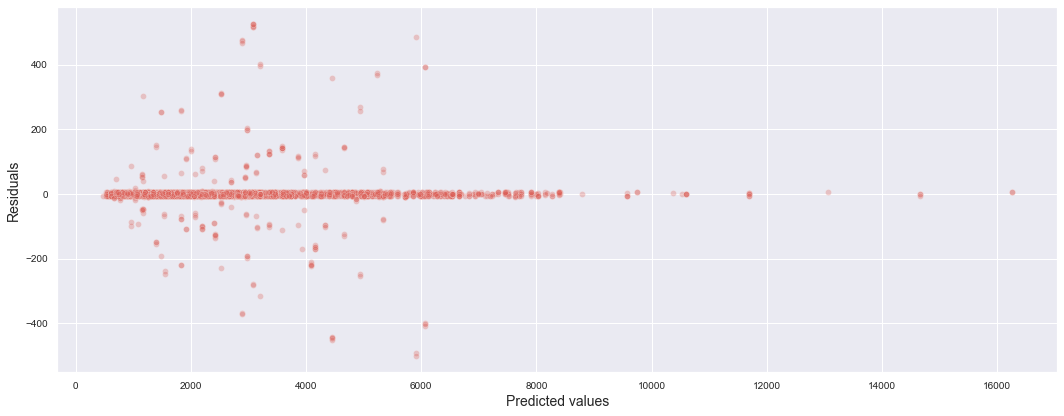

In [66]:
# Prints summary report.
def summaryReport(gridsearch):
    y_pred= gridsearch.predict(X_test) 
    d_final = {'RMSE':[], 'MSE':[], 'MAPE':[]}
    d_final['RMSE'].append(mean_squared_error(y_test, y_pred,squared=False))
    d_final['MSE'].append(mean_squared_error(y_test, y_pred))
    d_final['MAPE'].append(mean_absolute_percentage_error(y_test,y_pred))
    display(pd.DataFrame(d_final))
    print('Root mean squared error: ',mean_squared_error(y_test, y_pred,squared=False))
    print('Mean squared error: ',mean_squared_error(y_test, y_pred))
    print('Mean Absolute percentage error:', mean_absolute_percentage_error(y_test,y_pred))
    
    plt.subplots(figsize=(15, 6), tight_layout=True)
    residuals = y_test-y_pred
    sns.scatterplot(x = y_pred,y =residuals,alpha=.3)

    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.show()

    
    return y_pred,gridsearch,residuals
y_hat,gsrch,resid = summaryReport(fitted_grid)

In [56]:
np.mean(resid)

0.5383977856526376

$actual - predicted =  y - \hat{y} = residual$

### Errors the model make?
1. Residual plots help us to determine whether a model is appropriate in modelling the given data
2. We can see that from the residual plot, some points are scattered randomly from the y=0 line, we can conclude that the model is very approriate in our scenario. However if the residual plots follow a pattern, then it would not be a good model.
3. Our mean residuals is shown above, and since the residuals are positive, means the model has slighly underpredicted the price of PCs

# Feature importances

<!-- # fi_pipe = Pipeline([
# ('preprocess', preprocess),
# ('RFE', RFE(DecisionTreeRegressor(random_state=rstate) ,n_features_to_select = 0.4 )),
# ('Model', TransformedTargetRegressor(DecisionTreeRegressor(random_state=rstate), func=np.log,inverse_func=np.exp) )
# ])
# fi_pipe.set_params(**fitted_grid.best_params_)
# fi_pipe.fit(X_train,y_train)
# display() -->
1. We will use `permutation_importance` to provide us with feature importances.
2. `RAM` & `CPU Series` deemed as most relevant and important by model
3. CPU Brand not very relevant denoted by its low placement.

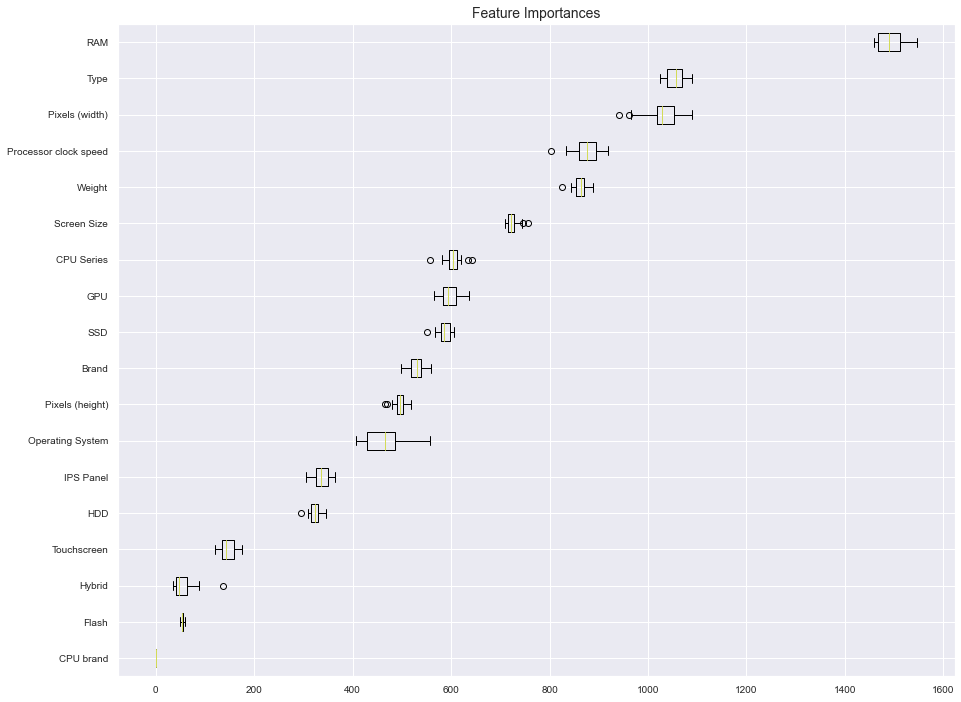

In [57]:
fig, ax = plt.subplots(figsize=(15, 12)) 
perm = permutation_importance(gsrch, X_test, y_test, n_repeats = 20,scoring=rmse, random_state =rstate)
ax.boxplot(pd.DataFrame(perm.importances[perm.importances_mean.argsort()].T), labels=X_test.columns[perm.importances_mean.argsort()],vert=False)
plt.title("Feature Importances")
fig.show()

## Saving model using joblib

In [58]:
import joblib
joblib.dump(gsrch, 'dc.pkl')

['dc.pkl']

## Conclusion:
We have managed to perform extensive feature subsetting and data preparation on PC components/aspects to obtain a model with relatively good $RMSE$ scores at the same time avoiding the curse of dimensionality. Through thoroughly evaluating each different regression model categories by analysing its pros and cons, we have ended up with DecisionTreeRegressor as our best model. 
Moreover, we have managed to utilize feature selection techniques to select the most relevant features for our model. Apart from this, we have also managed to overcome the bias variance trade off through extensively performing hyperparameter tuning by reading up more about pruning, and other relevant hyperparameters. 
Finally, our model sits between the 2 extremes of overfitting and underfitting and we have more or less fulfilled our objective.

# References:
1. https://www.hp.com/us-en/shop/tech-takes/what-are-typical-monitor-sizes